# Synthesize EIS data via kernel density estimation and Latin hypercube sampling

In [1]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
import os, sys 
import pandas as pd
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
import scipy
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from PEMFC_project import _samplings , _equivalent_circuits, _reconstruct_Nyquist_plot,_data_summery 

import pickle

# Load Gaussian process classifier which has been trained from original dataset (EIS_O2_STOI.csv) 
with open('Models/gpc_smote_3.pkl','rb') as f:
    gpc = pickle.load(f)
    
def GPC(x) :
    o2_stoi = [1.4, 1.5, 1.8, 2.0, 2.2, 2.5, 3.0]
    y_c = gpc.predict(x)
    return np.array([o2_stoi[i] for i in y_c.astype(int)])

C:\Users\mero_\anaconda3\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator _BinaryGaussianProcessClassifierLaplace from version 0.23.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\mero_\anaconda3\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\mero_\anaconda3\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator OneVsRestClassifier from version 0.23.2 when using version 1.2.2. This might lead to breaking code or inv

In [2]:
scaler_c =MinMaxScaler()
X_train_c = pd.read_csv('Data/x_smote_enn_train_1.csv',header=0,index_col=None)
y_train = pd.read_csv('Data/y_smote_enn_train_1.csv',header=0,index_col=None)
scaler_c.fit(X_train_c)

MinMaxScaler()

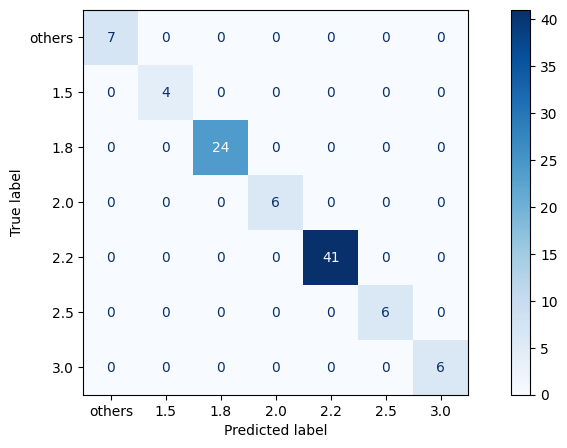

In [3]:
eis_test = pd.read_csv('Data/x_smote_enn_test_1.csv',header=0,index_col=None)
y_test = pd.read_csv('Data/y_smote_enn_test_1.csv',header=None,index_col=None)
X_test_c = scaler_c.transform(eis_test)
test = gpc.predict(X_test_c)
y_c_count = pd.Series(test).replace([ 0, 1, 2, 3, 4, 5, 6], [ 1.4, 1.5, 1.8, 2.0, 2.2, 2.5, 3.0])

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 
y_c_test = y_test.replace([ 1.4, 1.5,1.6, 1.8, 2.0, 2.2, 2.5, 3.0],[ 0, 1,0, 2, 3, 4, 5, 6])
cm = confusion_matrix(test, y_c_test.values)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['others', 1.5, 1.8, 2.0, 2.2, 2.5, 3.0] )# displace_la
disp.plot(cmap=plt.cm.Blues)
plt.rcParams.update({'font.size': 15})
plt.show()

## Kernel density estimation

In [4]:
### Identify the equivalent ciruit parameters in the training dataset

ind_1d4 = np.where(y_train==1.4)[0]
params_1d4 = _equivalent_circuits.circuits_components_params(X_train_c.loc[ind_1d4])


ind_1d5 = np.where(y_train==1.5)[0]
params_1d5 = _equivalent_circuits.circuits_components_params(X_train_c.loc[ind_1d5])

ind_1d8 = np.where(y_train==1.8)[0]
params_1d8 = _equivalent_circuits.circuits_components_params(X_train_c.loc[ind_1d8])

ind_2d2 = np.where(y_train==2.2)[0]
params_2d2 = _equivalent_circuits.circuits_components_params(X_train_c.loc[ind_2d2])

ind_2d5 = np.where(y_train==2.5)[0]
params_2d5 = _equivalent_circuits.circuits_components_params(X_train_c.loc[ind_2d5])

ind_3d0 = np.where(y_train==3.0)[0]
params_3d0 = _equivalent_circuits.circuits_components_params(X_train_c.loc[ind_1d8])

In [49]:
## the means of equivalent ciruit parameters regarding oxygen stoichiometry

means={1.4:[8.14e-9,0.001335,7.262,0.7012,0.03457,3.489e10,0.06437],
       1.6:[7.801e-9,0.001428,2.515,0.8746,0.006718,13.34,0.008932],
       1.8:[5.597e-9,0.001461,2.261,0.8754,0.005669,18.04,0.005489],
       2.0:[5.5999e-9,0.001446,2.315,0.8657,0.004596,25.17,0.003653],
       2.5:[5.5967e-9,0.00147,1.819,0.8864,0.003366,39.95,0.00175],
       3.0:[6.2e-9,0.001415,1.97,0.8601,0.003186,62.87,0.001052]
      }
t_means = pd.DataFrame(means, index=['L','Rm','Q','phi','Rct','Cdl','Rt']).T
t_means

,L,Rm,Q,phi,Rct,Cdl,Rt
1.4,8.140000e-09,0.001335,7.262,0.7012,0.034570,3.489000e+10,0.064370
1.6,7.801000e-09,0.001428,2.515,0.8746,0.006718,1.334000e+01,0.008932
1.8,5.597000e-09,0.001461,2.261,0.8754,0.005669,1.804000e+01,0.005489
2.0,5.599900e-09,0.001446,2.315,0.8657,0.004596,2.517000e+01,0.003653
2.5,5.596700e-09,0.001470,1.819,0.8864,0.003366,3.995000e+01,0.001750
3.0,6.200000e-09,0.001415,1.970,0.8601,0.003186,6.287000e+01,0.001052


In [50]:
samples_1 = []
samples_2 = []

In [51]:
# Generate data and setting value scale of parameters 
upper = [0.6*x for x in params_1d8.mean()]


for i in range(100):
    samples = _samplings.latin_hypercube_uniform(10,7) # L,Rm,Q,phi,Rct,C,Rt,omega
    # setting numerical scale of parameters
    samples[:,0]=samples[:,0]*2e-8+1e-9      #L
    samples[:,1]=samples[:,1]*upper[1]#*2e-3 #R_ohm 
    samples[:,2]=samples[:,2]*upper[2]          #Q
    samples[:,3]=samples[:,3]*0.5+0.5   #phi
    samples[:,4]=samples[:,4]*upper[4] #R_ct
    samples[:,5]=samples[:,5]*upper[5]#*50 #C
    samples[:,6]=samples[:,6]*upper[6] #Rt
    if i==0 : samples_1 = samples.copy()
    else: samples_1 = np.vstack((samples_1,samples))

In [52]:
samples_2 = samples_1.copy()

In [53]:
# Generate data and setting value scale of parameters 
upper = [2*x for x in params_1d4.mean()]


for i in range(100):
    samples = _samplings.latin_hypercube_uniform(10,7) # L,Rm,Q,phi,Rct,C,Rt,omega
    # setting numerical scale of parameters
    samples[:,0]=samples[:,0]*2e-8+1e-9      #L
    samples[:,1]=samples[:,1]*upper[1]+0.001#*2e-3 #R_ohm 
    samples[:,2]=samples[:,2]*upper[2]+0.5          #Q
    samples[:,3]=samples[:,3]*0.5+0.5   #phi
    samples[:,4]=samples[:,4]*upper[4]+0.001 #R_ct
    samples[:,5]=samples[:,5]*upper[5]+20#*50 #C
    samples[:,6]=samples[:,6]*upper[6]+0.0005 #Rt
    if i==0 : samples_1 = samples.copy()
    else: samples_1 = np.vstack((samples_1,samples))

In [54]:
samples_2 = np.vstack((samples_2,samples_1))

In [55]:
# Generate data and setting value scale of parameters 
upper = [0.8*x for x in params_2d5.mean()]


for i in range(100):
    samples = _samplings.latin_hypercube_uniform(10,7) # L,Rm,Q,phi,Rct,C,Rt,omega
    # setting numerical scale of parameters
    samples[:,0]=samples[:,0]*2e-8+1e-9      #L
    samples[:,1]=samples[:,1]*upper[1]#*2e-3 #R_ohm 
    samples[:,2]=samples[:,2]*upper[2]          #Q
    samples[:,3]=samples[:,3]*0.5+0.5   #phi
    samples[:,4]=samples[:,4]*upper[4] #R_ct
    samples[:,5]=samples[:,5]*upper[5]#*50 #C
    samples[:,6]=samples[:,6]*upper[6] #Rt
    if i==0 : samples_1 = samples.copy()
    else: samples_1 = np.vstack((samples_1,samples))

In [56]:
samples_2 = np.vstack((samples_2,samples_1))

In [57]:

rng = np.random.default_rng()
rng.shuffle(samples_2,axis=0)
    
zf_samples = np.zeros([samples_2.shape[0],62])
for i in range(samples_2.shape[0]):
    zf=_equivalent_circuits.zf_cal(samples_2[i,0], samples_2[i,1],samples_2[i,2],samples_2[i,3],
                                  samples_2[i,4],samples_2[i,5],samples_2[i,6])
    zf_s = np.asarray(zf).ravel().reshape(1,-1)
    zf_samples[i,:] = zf_s

In [58]:
zf_stand = scaler_c.transform(zf_samples)
y_c_pred = gpc.predict(zf_stand)
y_c_count = pd.Series(y_c_pred).replace([0, 1, 2, 3, 4, 5, 6], ['others', 1.5, 1.8, 2.0, 2.2, 2.5, 3.0])

_data_summery.target_summery(y_c_count)

C:\Users\mero_\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


,counts,proportion
3.0,1568,0.522667
2.2,714,0.238000
1.8,408,0.136000
others,287,0.095667
2.0,23,0.007667


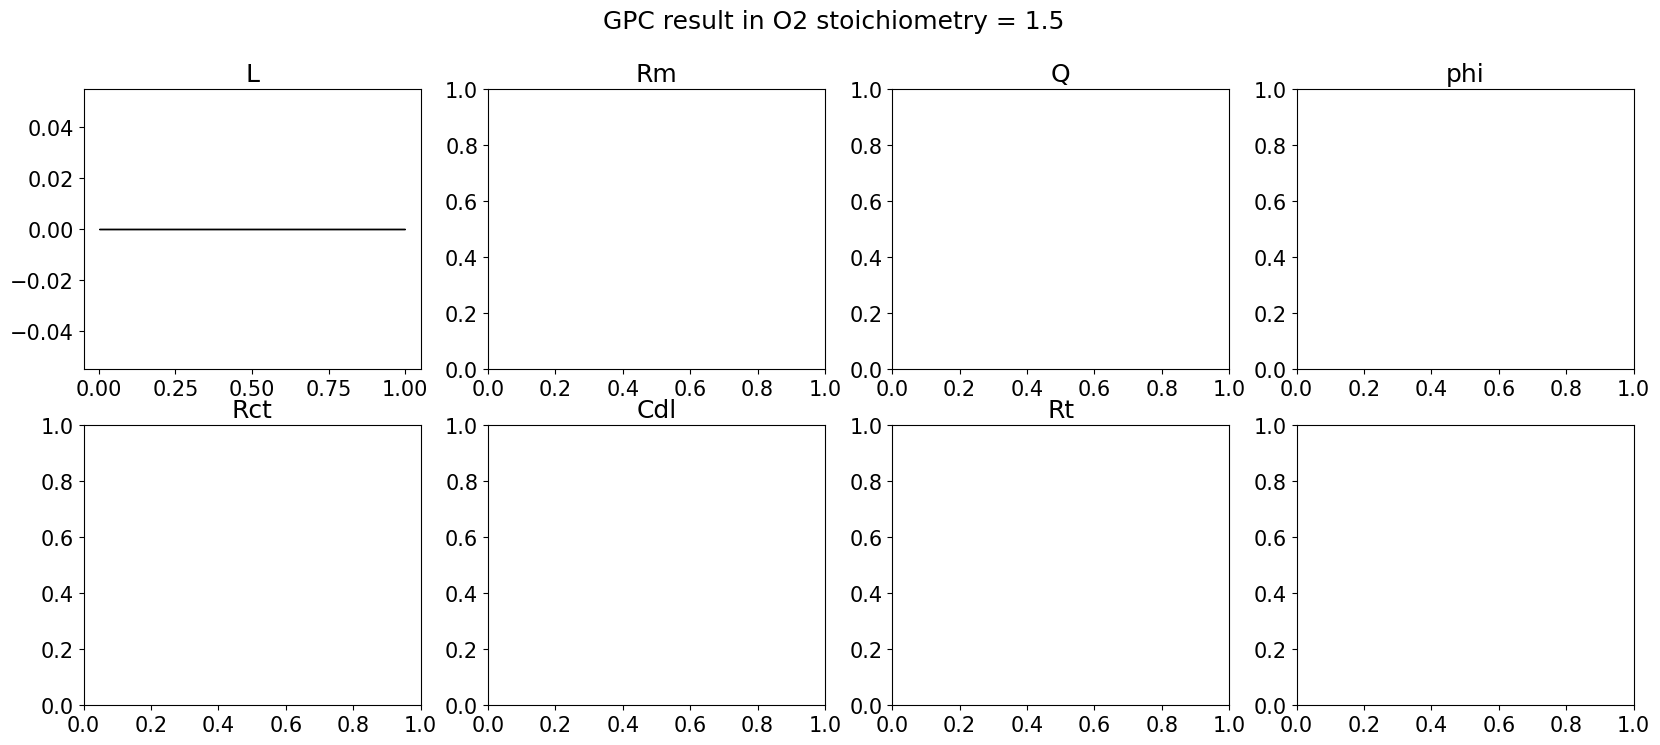

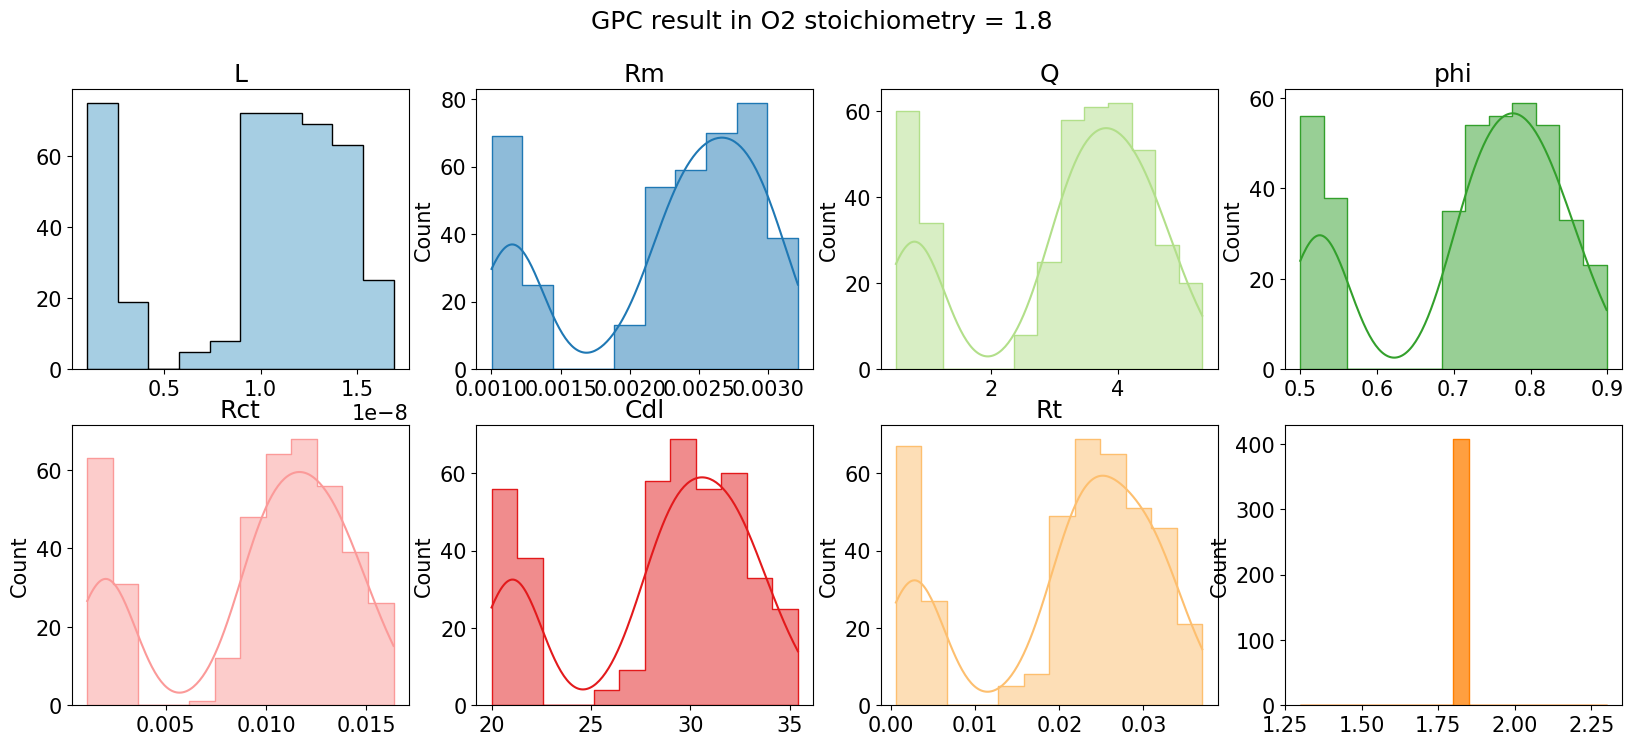

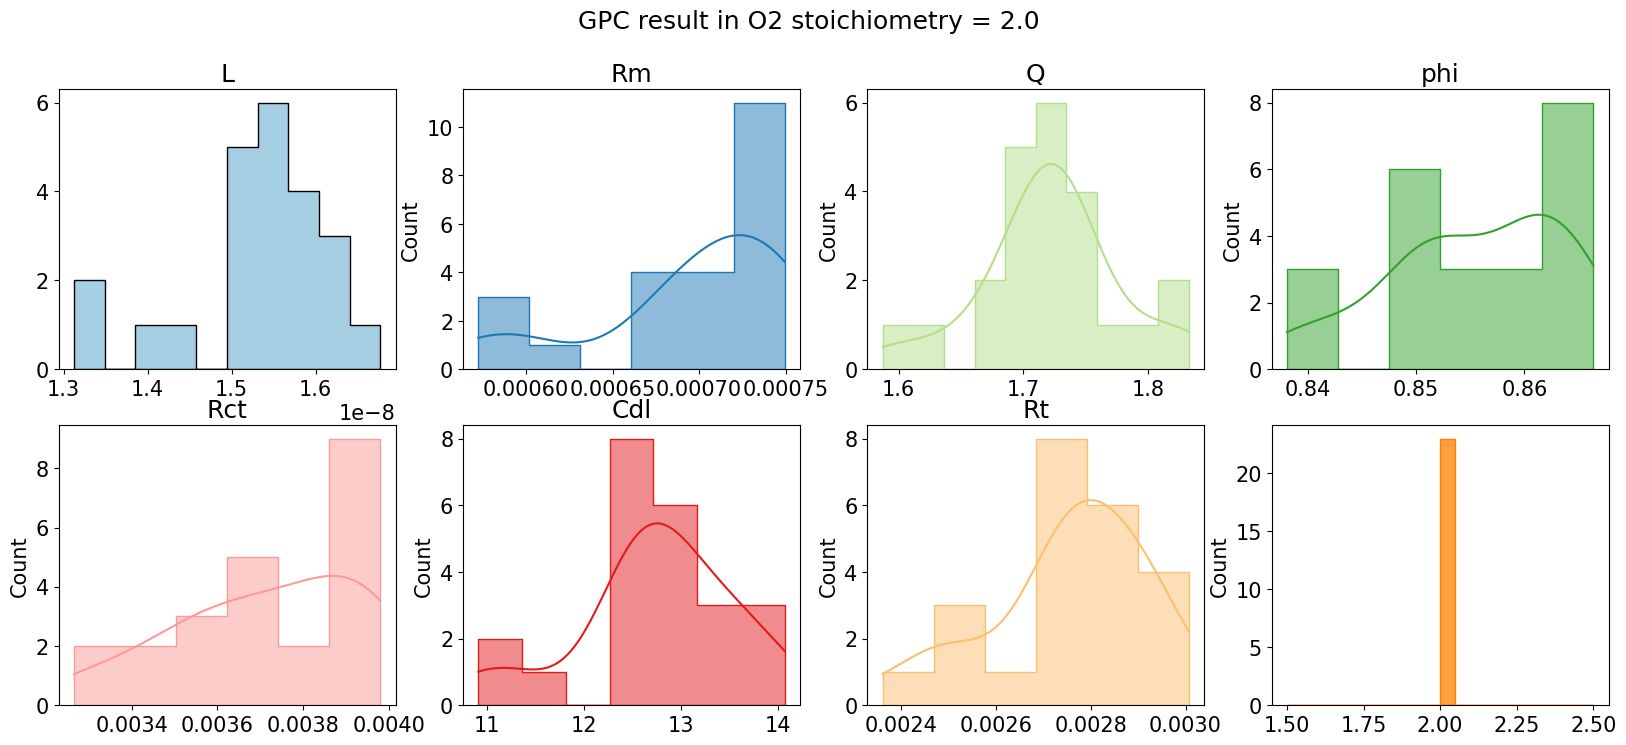

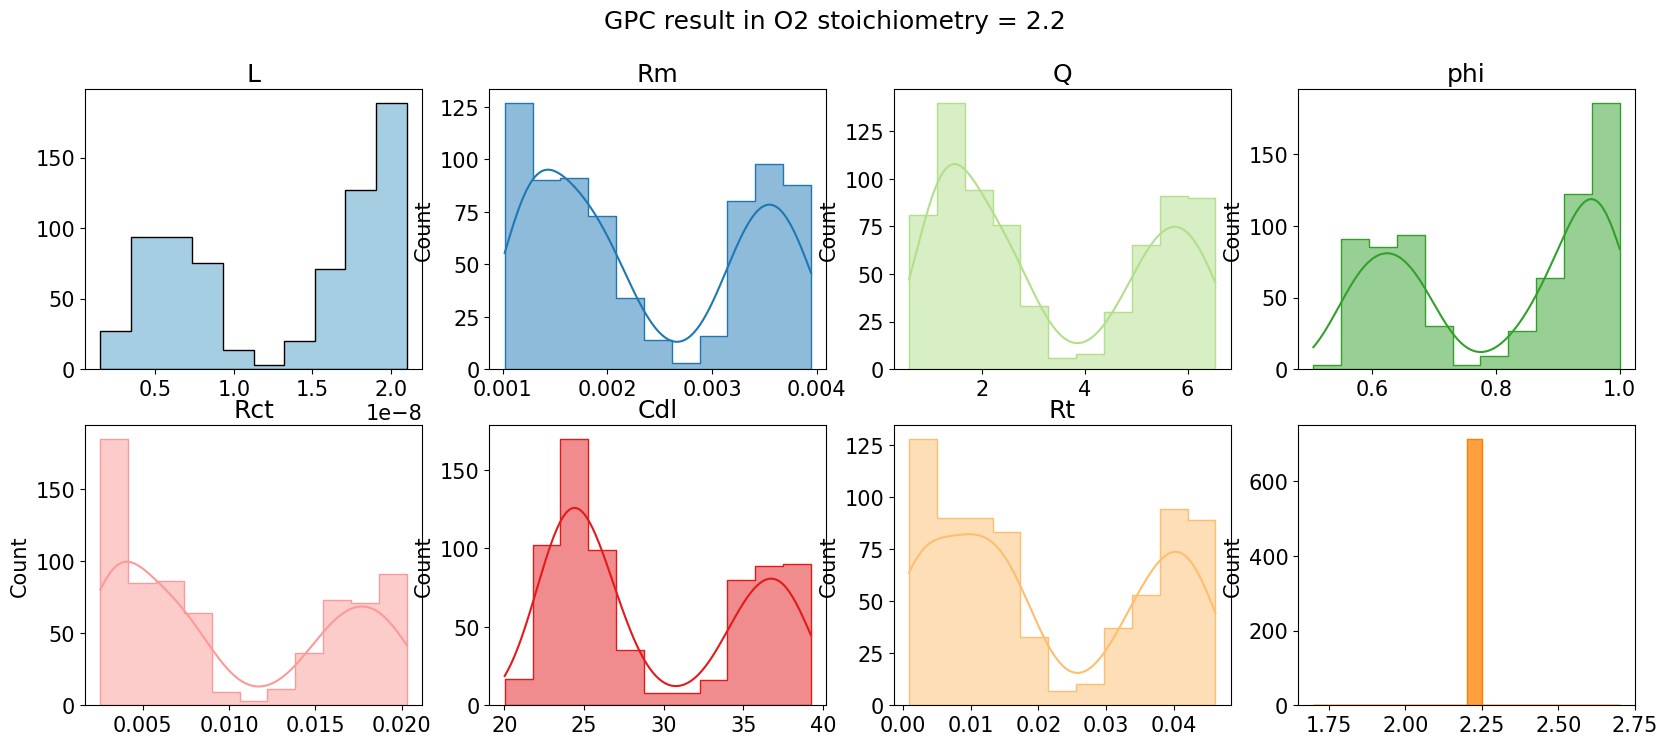

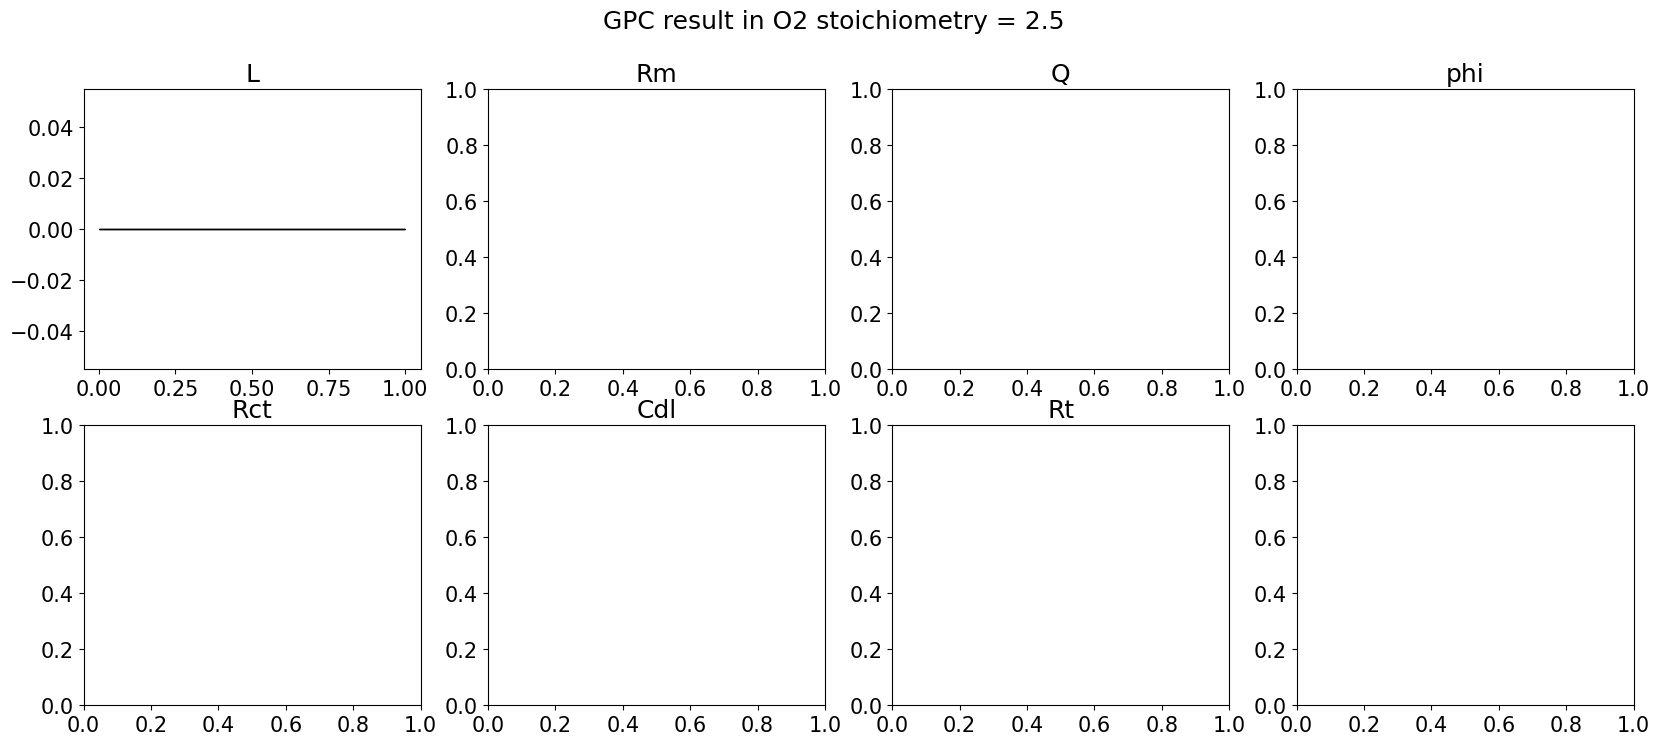

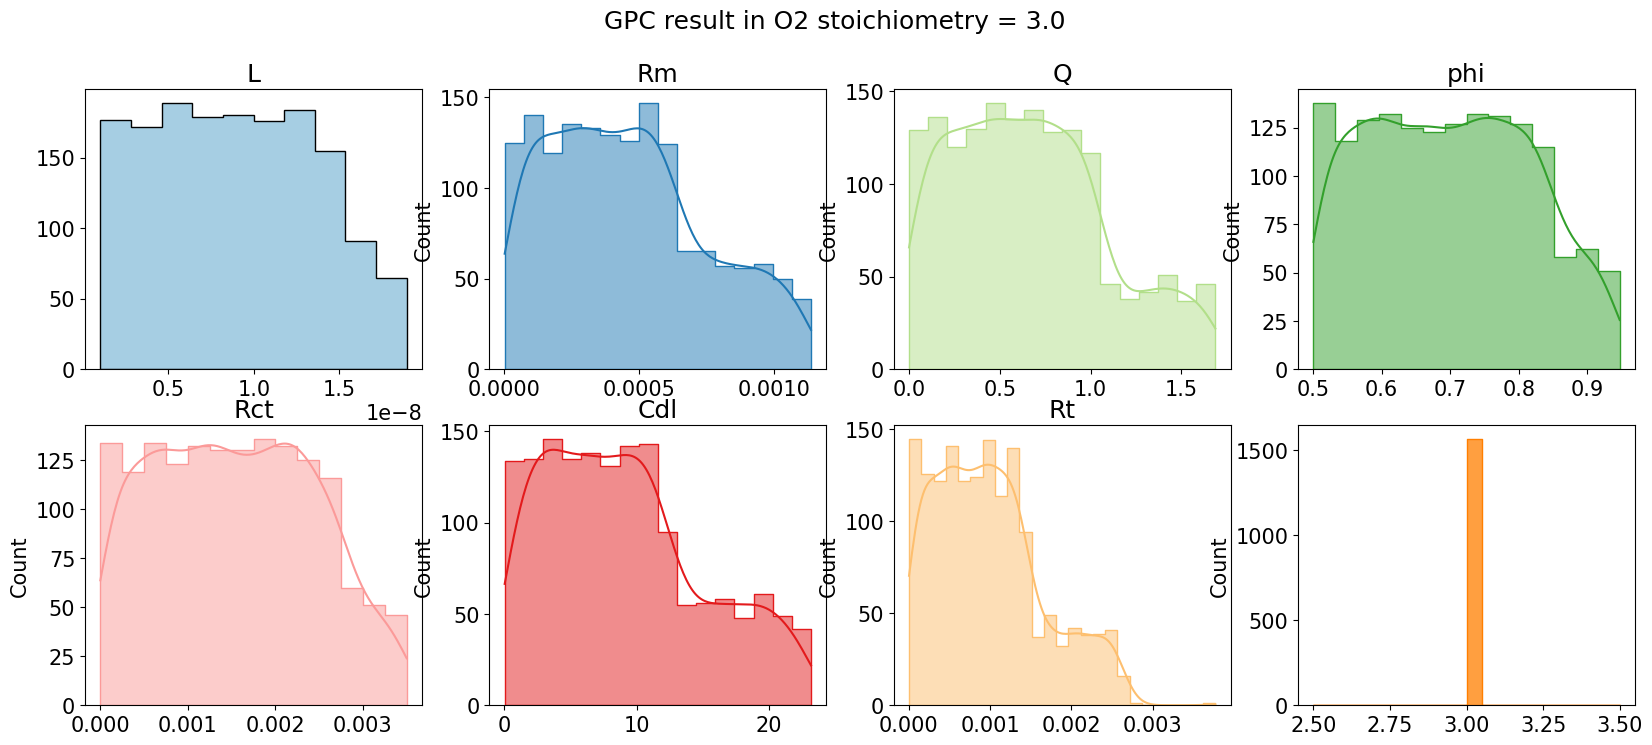

In [59]:
get_yc=[]
get_zf=[]
get_param=[]
O2stoi = [1.5, 1.8, 2.0, 2.2, 2.5, 3.0]
for stoi in O2stoi:
    yc, zf, param = _reconstruct_Nyquist_plot.get_points_c(stoi, y_c_count,zf_samples, samples_2)
    get_yc.append(yc)
    get_zf.append(zf)
    get_param.append(param)
    _reconstruct_Nyquist_plot.plot_param_dist(param,yc,plt_title='GPC result in O2 stoichiometry = %0.1f'%stoi, plot_kde=True)
    print()

## Generate synthetic EIS data based on the estimated EC parameters from kernel density estimation  

In [46]:
posit = 3
stoi =  get_yc[posit][1]
print(stoi)
param_new_1 = _reconstruct_Nyquist_plot.KDE_generate_params(get_param[posit], 1000)

2.2


C:\Users\mero_\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [-9815.55859108           -inf -8163.39887635           -inf
 -6793.29027605           -inf -5657.29209977           -inf
 -4715.60236253           -inf -3935.1749504            -inf
 -3288.57153457           -inf -2753.00890931           -inf
 -2309.56882879           -inf -1942.54269684           -inf
 -1638.88774313           -inf -1387.77493478           -inf
 -1180.21231901           -inf -1008.73094376           -inf
  -867.1237125            -inf  -750.23007199           -inf
  -653.76048082           -inf  -574.15366146           -inf
  -508.45846045           -inf  -454.23358813           -inf
  -409.46221039           -inf  -372.48045101           -inf
  -341.91770285           -inf  -316.64552693           -inf
  -295.73367451           -inf  -278.41434425           -inf
  -264.05543109           -inf  -252.14028069           -inf
  -

In [60]:
rng.shuffle(param_new_1,axis=0)
param_new_1=np.delete(param_new_1,np.where(param_new_1<0),axis=0)
param_new_1[:,0] = param_new_1[:,0]*1e-5

zf_new_1 = np.zeros([param_new_1.shape[0],62])
for i in range(param_new_1.shape[0]):
    zf = _equivalent_circuits.zf_cal(param_new_1[i,0], param_new_1[i,1], param_new_1[i,2], param_new_1[i,3],
                                  param_new_1[i,4], param_new_1[i,5], param_new_1[i,6])
    zf_s = np.asarray(zf).ravel().reshape(1,-1)
    zf_new_1[i,:]=zf_s

In [61]:
zf_stand_1 = scaler_c.transform(zf_new_1)
y_c_pred_1 = gpc.predict(zf_stand_1)
y_c_count_1 = pd.Series(y_c_pred_1).replace([0, 1, 2, 3, 4, 5, 6], [1.4, 1.5, 1.8, 2.0, 2.2, 2.5, 3.0])
zf_new_sel_1 = zf_new_1[np.where(y_c_count_1==stoi)]
param_new_sel_1 = param_new_1[np.where(y_c_count_1==stoi)]
_data_summery.target_summery(y_c_count_1)

C:\Users\mero_\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


,counts,proportion
2.2,206,0.400778
1.5,132,0.256809
1.8,108,0.210117
1.4,34,0.066148
2.0,20,0.038911
3.0,9,0.017510
2.5,5,0.009728


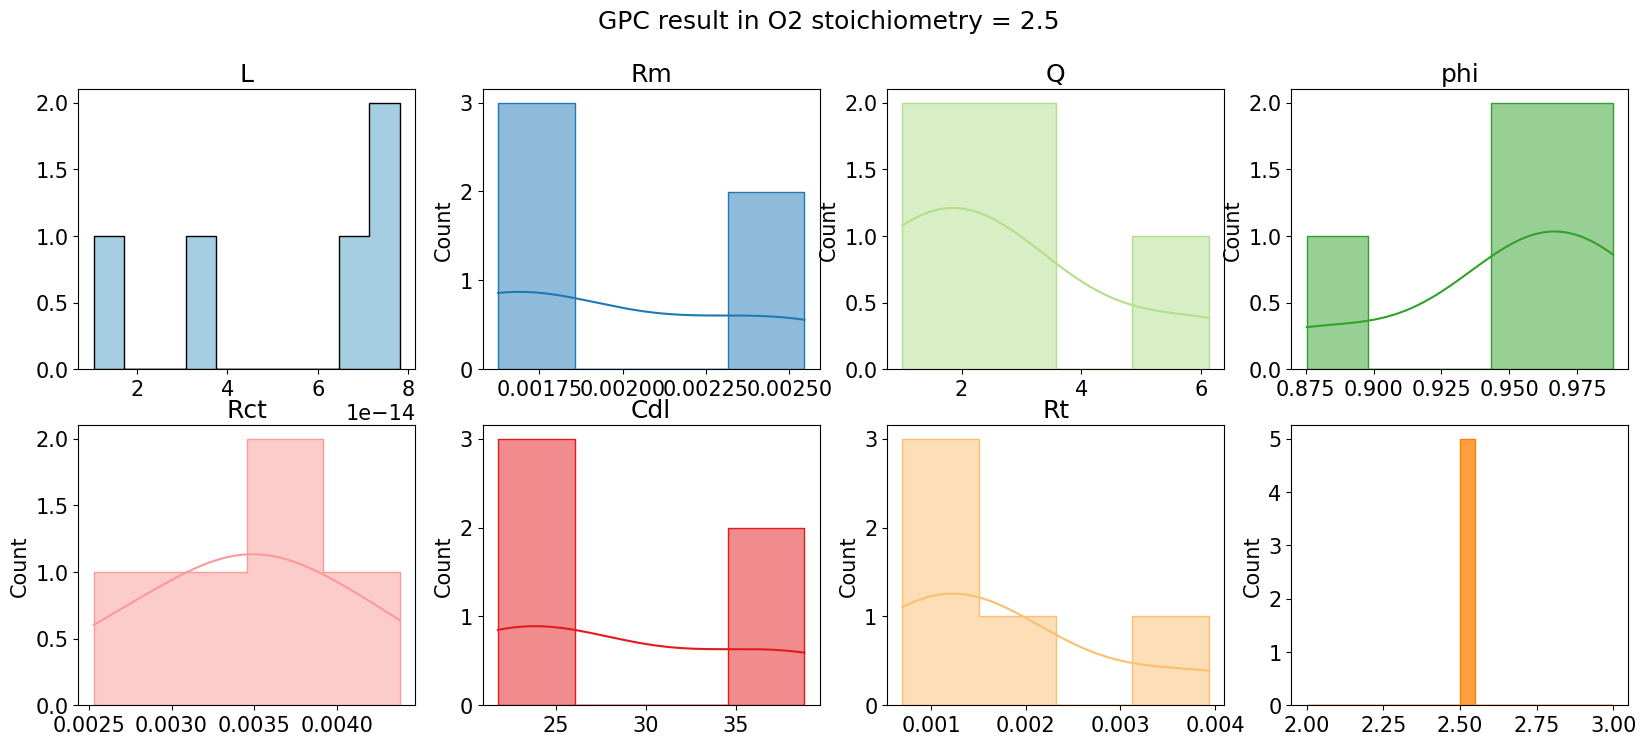

In [65]:
stoi =2.5
zf_new_2 = zf_new_1[np.where(y_c_count_1==stoi)]
param_new_2 = param_new_1[np.where(y_c_count_1==stoi)]

_reconstruct_Nyquist_plot.plot_param_dist(param_new_2,
                                          np.ones(param_new_2.shape[0])*stoi,

                                          plt_title='GPC result in O2 stoichiometry = %0.1f'%stoi, plot_kde=True)

In [66]:
### synthesize the small number of samples
param_new_2 = _reconstruct_Nyquist_plot.KDE_generate_params(param_new_2, 5000)

rng.shuffle(param_new_2,axis=0)
param_new_2=np.delete(param_new_2,np.where(param_new_2<0),axis=0)
param_new_2[:,0] = param_new_2[:,0]*1e-5

zf_new_2 = np.zeros([param_new_2.shape[0],62])
for i in range(param_new_2.shape[0]):
    zf = _equivalent_circuits.zf_cal(param_new_2[i,0], param_new_2[i,1], param_new_2[i,2], param_new_2[i,3],
                                  param_new_2[i,4], param_new_2[i,5], param_new_2[i,6])
    zf_s = np.asarray(zf).ravel().reshape(1,-1)
    zf_new_2[i,:]=zf_s

C:\Users\mero_\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [-1.18419967e+06            -inf -9.83142678e+05            -inf
 -8.16221651e+05            -inf -6.77640897e+05            -inf
 -5.62588737e+05            -inf -4.67070428e+05            -inf
 -3.87769465e+05            -inf -3.21932429e+05            -inf
 -2.67273380e+05            -inf -2.21894494e+05            -inf
 -1.84220161e+05            -inf -1.52942283e+05            -inf
 -1.26974856e+05            -inf -1.05416257e+05            -inf
 -8.75179457e+04            -inf -7.26584688e+04            -inf
 -6.03218858e+04            -inf -5.00798537e+04            -inf
 -4.15767545e+04            -inf -3.45173479e+04            -inf
 -2.86565204e+04            -inf -2.37907742e+04            -inf
 -1.97511620e+04            -inf -1.63974208e+04            -inf
 -1.36131017e+04            -inf -1.13015269e+04            -inf
 -9.38243266

C:\Users\mero_\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [ 4.9670245         -inf  5.00085348        -inf  5.02109927        -inf
  5.02930254        -inf  5.02665712        -inf  5.01411164        -inf
  4.99245255        -inf  4.96237531        -inf  4.92453805  5.02047005
  4.87959297  4.92743631  4.82819657  4.83440257  4.77100508  4.93753468
  4.70866218  4.98313038  4.64178506  5.00516946  4.5709524   4.91213572
  4.49669598  4.81910198  4.41949604  4.72606824  4.33977998  4.6330345
  4.25792357  4.54000076  4.17425386  4.44696702  4.08905316  4.35393328
  4.00256351  4.26089953  3.91499123  4.16786579  3.82651143  4.07483205
  3.73727213  3.98179831  3.64739806  3.88876457  3.55699408  3.79573083
  3.46614814  3.70269709  3.37493388  3.60966335  3.28341287  3.51662961
  3.19163651  3.42359586  3.09964769  3.33056212  3.00748218  3.23752838
  2.91516975  3.14449464  2.82273519  3.0514609   2.730

In [67]:
zf_stand_2 = scaler_c.transform(zf_new_2)
y_c_pred_2 = gpc.predict(zf_stand_2)
y_c_count_2 = pd.Series(y_c_pred_2).replace([0, 1, 2, 3, 4, 5, 6], [1.4, 1.5, 1.8, 2.0, 2.2, 2.5, 3.0])

_data_summery.target_summery(y_c_count_2)

C:\Users\mero_\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


,counts,proportion
1.8,820,0.485494
2.2,239,0.141504
1.4,218,0.129070
2.0,121,0.071640
2.5,111,0.065719
3.0,106,0.062759
1.5,74,0.043813


In [68]:
### Pile up to one dataset

zf_kde = np.concatenate((zf_new_1, zf_new_2), axis=0)
y_kde = np.concatenate((y_c_count_1, y_c_count_2), axis=0)
params_kde = np.concatenate((param_new_1, param_new_2), axis=0)

print(zf_kde.shape)
print(y_kde.shape)
print(params_kde.shape)

(2203, 62)
(2203,)
(2203, 7)
